### Installing
The primary purpose of the `c12simulator-clients` python package is to enable the integration of different quantum computer frameworks with the C12 Quantum Electronics simulator. Currently, the package supports only the integration with a Qiskit.

The `c12simulator-clients` package is publicly available on `PyPI`, and installing it quickly using the pip command is possible. Currently, the package is available on `Test PyPI`, a testing environment for uploading, managing, and testing Python modules. The installation procedure is quite similar for both PyPI environments. After installing the package via `pip`, we can upload it easily using import statements. Alongside our package, the python qiskit library and other library dependencies (pydantic and requests) are installed.

The tutorial for this package is divided into <b>five</b> jupyter notebooks.

 1. The first one is devoted to the basics of the Qiskit library, mainly creating the quantum circuits and performing the perfect simulation using Qiskit's Aer package. Also, we will briefly cover the OpenQASM format and its properties.

2. The second one shows the usage of the c12simulator-clients package for running the quantum circuits on the C12 simulator and obtaining the simulation results. The notebook also shows one example using a popular quantum algorithm: Groover's algorithm.

3. The third notebook explains how we can retrieve the information from the jobs that have already been run. Besides that, we will see how to run multiple circuits simultaneously.

4. The fourth notebook shows how to run circuits using plain API calls. This notebook demonstrates low-level communication with the C12 simulator.
5. The fifth notebook demonstrates how to get the mid-circuit states.
6. The sixth notebook demonstrates how we can obtain and change the physical parameters of the C12 system.



In [ ]:
# This part is intentionally commented on. However, it should be uncommented if you install all packages locally.

# # -q (quiet) option is added to disable the output of the pip command
# !python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple c12simulator-clients -q
#
# #  Install the matplotlib library for better visualization of the quantum circuits.
# !pip install matplotlib -q
# !pip install pylatexenc -q

### Qiskit basics

Qiskit is an open-source framework for working with quantum computers. It is maintained and developed by IBM. It provides tools for creating, manipulating, and simulating quantum circuits and running them on actual quantum computers (IBMQ provider). Qiskit also includes libraries for different quantum algorithms. It has a developed community (available on Slack) and detailed documentation (<a href="https://qiskit.org/documentation/">Qiskit documentation</a>). <br> <br>

The foundation of the Qiskit is module Terra,  which provides the essential tools to build and run quantum circuits. In addition, Terra defines the interfaces for an end-user experience and the layers of optimization, pulse scheduling, and backend communication. The detailed and more comprehensive tutorial can be found <a href="https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html">here</a>.



Aer module has different simulators that can imitate the working quantum computer. We can use Aer to verify that current and near-future quantum computers operate correctly. Aer provides a high-performance simulator framework for quantum circuits using the Qiskit software stack. It contains optimized C++ simulator backends for executing circuits compiled in Terra. Aer also provides tools for constructing highly configurable noise models for performing realistic noisy simulations of the errors that occur during execution on real devices.


To create a quantum circuit, we need to create an instance of the `QuantumCircuit` class and specify the number of qubits.


In [1]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(4) # Create a QuantumCircuit object with 4 qubits
circuit.draw() # Visualize the circuit (now, it is an empty circuit, but one should notice that the designation of the qubits starts from zero)

q_0: 
     
q_1: 
     
q_2: 
     
q_3:

After creating the empty circuit with its quantum registers, we can add the operators (gates) to develop and execute the circuit. In Qiskit, operators can be added to the circuit one by one. The complete list of available gates and their usage can be found in Qiskit's documentation.

For instance, see: <a href="https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html"> qiskit gates.</a>

It is important to note that gates (operators) are added to the circuit as a method call on the same circuit (QuantumCircuit) object.

In [2]:
circuit.h(2)     # Add a H (Hadamard) gate on qubit 3
circuit.cx(2, 3) # Add a CX (CNOT) gate on control qubit 3, and target qubit 4
circuit.x(0)     # Add Pauli X gate on the first qubit
circuit.draw()   # Draw the circuit

┌───┐     
q_0: ┤ X ├─────
     └───┘     
q_1: ──────────
     ┌───┐     
q_2: ┤ H ├──■──
     └───┘┌─┴─┐
q_3: ─────┤ X ├
          └───┘

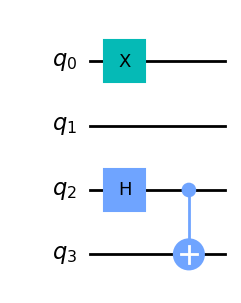

In [3]:
circuit.draw('mpl') # Drawing a circuit using matplotlib (prettier drawing)

Using Qiskit's `Aer` module, we can get the results of a perfect simulation of the desired quantum circuit. It means we will get the results without noise or errors, which is invalid for a real quantum computer in the NISQ era.

To perform a simulation using the Aer simulator, first, we must choose which backend will be used. In this context, the backend represents the machine for executing our circuit.

In this example, the quantum circuit will run on a `statevector` simulator backend which will execute on the local machine. After choosing the backend, we run the circuit by calling the `run()` method, which returns a `job` object that encapsulates all the necessary information about the circuit submitted for execution.

In [4]:
from qiskit import Aer

backend = Aer.get_backend("statevector_simulator")
job = backend.run(circuit)

The `job` object created after running the circuit on some backend has two essential methods. One is `status()`, which returns the status of the job, and the other is `result()`, which returns the job's result. Knowing that the job runs asynchronously is crucial, so we do not get the results automatically but have to wait for them.

There are two possible approaches for getting the result of one job:
- Call the `status()` method to check the current status of a job. If the status of a job is finished, we can get its results; if not, we can wait some time and recheck the status until the job is finished. In the end, we can get the job results.
-  Call the `result()` function, which will block while it waits for a job to finish. It will return when the job finishes its execution. </li>

In [5]:
from qiskit.providers import JobStatus
import time

# First approach
job_final_states = [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]
def get_job_result(job_obj):
    status = job_obj.status()
    if status in job_final_states:
        return job_obj.result()
    time.sleep(1)

result = get_job_result(job)
print(f"Counts: {result.get_counts()}")

# Second approach
result = job.result()
print(f"Statevector: {result.get_statevector().data}")

Counts: {'0001': 0.5, '1101': 0.5}
Statevector: [0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]


We can obtain the quantum circuit's OpenQASM format using the Qiskit library.

OpenQASM stands for the Open Quantum Assembly Language developed by IBM. It is a textual language that describes quantum circuits implemented on a quantum computer or simulated on a classical computer. It is a low-level language that allows quantum algorithms to be expressed in a way that is independent of the specific hardware being used.

 `qasm() `in Qiskit should convert our quantum circuit to the QASM format, but its functionality has known problems. For example, it could be possible that the obtained QASM string is wrong, especially for the larger circuits, so we need to pay attention when using this method and verify its results.

In [6]:
qasm_str = circuit.qasm()
print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[2];
cx q[2],q[3];
x q[0];



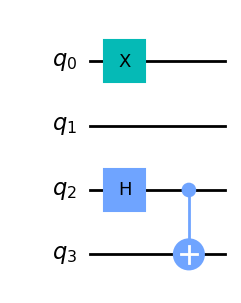

In [7]:
circuit2 = QuantumCircuit.from_qasm_str(qasm_str)
circuit2.draw('mpl')